# Intrinsic Dimension
* Dense and sparse projections
?https://discuss.pytorch.org/t/fast-walsh-hadamard-transform/19341

In [ ]:
# sys.path.append(str(Path.cwd().parent))
# from utils.train_val import train_net #, train_epoch, validate_epoch, save_checkpoint
# from utils.data_loaders import mnist_loaders

# # sys.path.append(str(Path.cwd().parent.parent))
# # from pytorch_testing.tests.unit_tests import Tester, SimpleNet

# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

# DEVICE = torch.device("cuda:1")
# PATH = '../data/'

In [ ]:
import os
import sys
import math
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.random_projection import SparseRandomProjection as SRP
from scipy.sparse import find
from sklearn.preprocessing import normalize


sys.path.append(str(Path.cwd().parent))
from utils.train_val import train_net #, train_epoch, validate_epoch, save_checkpoint
from utils.data_loaders import mnist_loaders

# sys.path.append(str(Path.cwd().parent.parent))
# from pytorch_testing.tests.unit_tests import Tester, SimpleNet

%reload_ext autoreload
%autoreload 2
%matplotlib inline

DEVICE = torch.device("cuda:1")
PATH = '../data/'

In [104]:
class SmallFCNetMNIST(nn.Module):
    def __init__(self):
        super(SmallFCNetMNIST, self).__init__()
        self.layers = torch.nn.ModuleDict()
        self.layers['fc1'] = nn.Linear(28*28, 128)
        self.layers['fc2'] = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.layers['fc1'](x))
        x = self.layers['fc2'](x)
        return F.log_softmax(x, dim=1)

In [ ]:
train_loader, val_loader = mnist_loaders(PATH, bs=256)
model = SmallFCNetMNIST().to(DEVICE)
metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
print('SmallFCNetMNIST Acc with all params:', metrics['val']['best_acc'])

## Dense matrix projection

In [3]:
class DenseProjSmallFCNetMNIST(nn.Module):        
    def __init__(self, d, DEVICE='cuda'):
        super(DenseProjSmallFCNetMNIST, self).__init__()
        self.layers = torch.nn.ModuleDict()
        self.layers['fc1'] = nn.Linear(28*28, 128)
        self.layers['fc2'] = nn.Linear(128, 10)
        self.d = d
#         self.opt_basis= torch.zeros(self.d).to(DEVICE)
        self.opt_basis = nn.Parameter(torch.zeros(self.d).to(DEVICE), requires_grad=True)

        self.get_projection_matrix()
            
    def get_projection_matrix(self):
        self.D = 0
        for name, layer in self.layers.items():
            self.D += torch.prod(torch.tensor(layer.weight.size()))
            if layer.bias is not None:
                self.D += torch.prod(torch.tensor(layer.bias.size()))
            layer.requires_grad = False # none of the layers will be updated
        
        proj_matrix = nn.Parameter(torch.randn(self.D, self.d).to(DEVICE), requires_grad=False)
        proj_matrix = F.normalize(proj_matrix, dim=0, p=2)
        
        # Turn it into a nice format for a weight and bias matrix for each layer
        param_idx = 0
        self.projection = {}
        for name, layer in self.layers.items():
            self.projection[name] = {}
            n_weight_params = torch.prod(torch.tensor(layer.weight.size()))
            self.projection[name]['weight'] = proj_matrix[param_idx : param_idx + n_weight_params, :]
            self.projection[name]['weight'].requires_grad = False
            # also make sure the layers aren't trainable
            self.layers[name].weight.requires_grad = False
            param_idx += n_weight_params
            if layer.bias is not None:
                n_bias_params = torch.prod(torch.tensor(layer.bias.size()))
                self.projection[name]['bias'] = proj_matrix[param_idx : param_idx + n_bias_params, :]
                self.projection[name]['bias'].requires_grad = False
                # also make sure the layers aren't trainable
                self.layers[name].bias.requires_grad = False
                param_idx += n_bias_params
#         print(f'Model contains {self.D} params, but only optimizing a {self.d} dim subspace')

    def forward(self, x):
        x = x.view(-1, 28*28)
        new_weight = self.layers['fc1'].weight + torch.matmul(self.projection['fc1']['weight'], self.opt_basis
                                                   ).view(self.layers['fc1'].weight.size())
        new_bias = self.layers['fc1'].bias + torch.matmul(self.projection['fc1']['bias'], self.opt_basis
                                                   ).view(self.layers['fc1'].bias.size())
        x = F.linear(input = x, 
                     weight=new_weight, 
                     bias=new_bias
                    )
        x = F.relu(x)
        
        new_weight = self.layers['fc2'].weight + torch.matmul(self.projection['fc2']['weight'], self.opt_basis
                                                   ).view(self.layers['fc2'].weight.size())
        new_bias = self.layers['fc2'].bias + torch.matmul(self.projection['fc2']['bias'], self.opt_basis
                                                   ).view(self.layers['fc2'].bias.size())
        x = F.linear(input = x,
                     weight=new_weight, 
                     bias=new_bias
                    )
        return F.log_softmax(x, dim=1)

In [4]:
train_loader, val_loader = mnist_loaders(PATH, bs=256)
model = DenseProjSmallFCNetMNIST(d=1024, DEVICE=DEVICE).to(DEVICE)
metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
print(f'DenseProjSmallFCNetMNIST Acc with 1024 params: {metrics["val"]["best_acc"]}')

DenseProjSmallFCNetMNIST Acc with 1024 params: 0.9064


In [14]:
d_list = [8, 16, 32, 64, 128, 256, 512, 1024, 2056]
results = []
for d in d_list:
    train_loader, val_loader = mnist_loaders(PATH, bs=256)
    model = DenseProjSmallFCNetMNIST(d=d, DEVICE=DEVICE).to(DEVICE)
    metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
    print(f'DenseProjSmallFCNetMNIST Acc with {d} params: {metrics["val"]["best_acc"]}')
    results.append(metrics["val"]["best_acc"])

DenseProjSmallFCNetMNIST Acc with 8 params: 0.1602
DenseProjSmallFCNetMNIST Acc with 16 params: 0.2389
DenseProjSmallFCNetMNIST Acc with 32 params: 0.3351
DenseProjSmallFCNetMNIST Acc with 64 params: 0.5496
DenseProjSmallFCNetMNIST Acc with 128 params: 0.6981
DenseProjSmallFCNetMNIST Acc with 256 params: 0.8053
DenseProjSmallFCNetMNIST Acc with 512 params: 0.8829
DenseProjSmallFCNetMNIST Acc with 1024 params: 0.9248
DenseProjSmallFCNetMNIST Acc with 2056 params: 0.9486


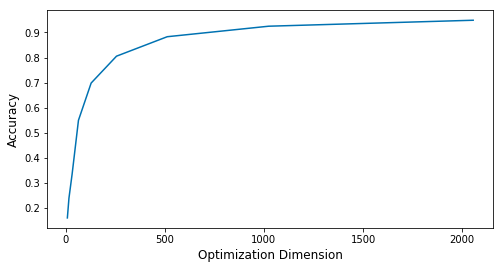

In [26]:
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(d_list, results)#, label='', linewidth=2)

# ax.set_ylim([560,740])
ax.set_xlabel('Optimization Dimension', fontsize='large')
ax.set_ylabel('Accuracy', fontsize='large')
# ax.legend(loc='best', prop={'size': 10})
# ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig('../output/imgs/DenseProjSmallFCNetMNIST.png', bbox='tight')
plt.show()

## CNN with sparse projection
* Implement a slightly more general model to compute intrinsic dimension for a CNN. 
* Use a sparse matrix instead of dense for projection to save memory

In [2]:
class IntrinsicNetSparse(nn.Module):
    ''' Optimize subspace of parameters of network defined as  using dense projection.
    
    d: intrinsic dimension size to test
    layers: torch.nn.ModuleDict()
    config: dict with same keys as layers, containing 3 objects: 
            'type' (str): type of layer
            'params' (dict) : all the params to specify the layer (type, ...)
            'activation' (dict) : if there is an activation after the layer
    
    ??? This still won't work for resnets, or any other more complex network
    '''
    
    def __init__(self, d, layers, config, DEVICE='cuda'):
        super(IntrinsicNetSparse, self).__init__()
        self.d = d
        self.layers = layers
        self.config = config
        self.opt_basis = nn.Parameter(torch.zeros(self.d).to(DEVICE), requires_grad=True)
        
        self.D = 0
        for name, layer in self.layers.items():
            self.D += torch.prod(torch.tensor(layer.weight.size()))
            if layer.bias is not None:
                self.D += torch.prod(torch.tensor(layer.bias.size()))
            layer.requires_grad = False # none of the layers will be updated
        self.D = self.D.item()

        self.get_projection_matrix()
        
    def slice_sparse_tensor(self, sparse_t, idx, dim):
        # some from https://stackoverflow.com/questions/50666440/column-row-slicing-a-torch-sparse-tensor

#         def isin(ar1, ar2): Too much memory, even on cpu
#             print('ar1.device', ar1.device)
#             print('ar2.device', ar2.device)
#             return (ar1[..., None] == ar2).any(-1)

        def compact1D(x):
            """ NORMALIZE indices to begin at 0 for new sliced tensor
            "Compact" values 1D uint tensor, so that all values are in [0, max(unique(x))].
            """
            x_sorted, x_sorted_ind = torch.sort(x, descending=True)
            x_sorted_unique, x_sorted_unique_ind = torch.unique(x_sorted, return_inverse=True)
            x[x_sorted_ind] = x_sorted_unique_ind
            return x

        idx = torch.tensor(idx)
        sparse_i = sparse_t._indices()
        sparse_v = sparse_t._values()

        # find indices that are in the sparse tensor
        # getting an error, so do it on cpu. CPU is too much memory, so do more efficient np method
        existing_idx = np.isin(sparse_i[dim].cpu().numpy(), idx.cpu().numpy())
        existing_idx = torch.from_numpy(existing_idx).byte().to(DEVICE)
        
        existing_idx = existing_idx.nonzero().squeeze()
        sparse_i = sparse_i.to(DEVICE)
        
        # keep only existing indices
        v_sliced = sparse_v[existing_idx]

        # grab the indices that we want to keep
        i_sliced = sparse_i.index_select(dim=1, index=existing_idx)

        # Building sparse result tensor:
        i_sliced[0] = compact1D(i_sliced[0])
        i_sliced[1] = compact1D(i_sliced[1])

        # find the new size
        size_sliced = torch.tensor(sparse_t.size())
        size_sliced[dim] = len(idx)
        size_sliced = (size_sliced[0], size_sliced[1]) 
        
        subset_sparse_t = torch.sparse.FloatTensor(i_sliced.to(DEVICE), v_sliced.to(DEVICE), size_sliced)
        return subset_sparse_t.to(DEVICE)
    
    def get_projection_matrix(self):
        M = SRP(self.d)._make_random_matrix(self.D, self.d)
        M = normalize(M, norm='l2', axis=0)
        fm=find(M)
        
        idx = torch.LongTensor(np.array([fm[0],fm[1]]))
        vals = torch.tensor(fm[2])
        proj_matrix = torch.sparse.FloatTensor(idx, vals, (self.D, self.d))
        
        # Turn it into a nice format for a weight and bias matrix for each layer
        p_idx = 0
        self.projection = {}
        for name, layer in self.layers.items():
            self.projection[name] = {}
            n_weights = torch.prod(torch.tensor(layer.weight.size()))
            self.projection[name]['weight'] = self.slice_sparse_tensor(proj_matrix, 
                                                                  idx=list(range(p_idx, p_idx + n_weights)), 
                                                                  dim=0).float()
            self.projection[name]['weight'].requires_grad = False
            # also make sure the layers aren't trainable
            self.layers[name].weight.requires_grad = False
            p_idx += n_weights
            if layer.bias is not None:
                n_weights = torch.prod(torch.tensor(layer.bias.size()))
                self.projection[name]['bias'] = self.slice_sparse_tensor(proj_matrix, 
                                                                  idx=list(range(p_idx, p_idx + n_weights)), 
                                                                  dim=0).float()
                self.projection[name]['bias'].requires_grad = False
                # also make sure the layers aren't trainable
                self.layers[name].bias.requires_grad = False
                p_idx += n_weights

    def get_layer_activation(self, name):
        mapping={'linear':F.linear,
                 'conv2d': F.conv2d,
                 'relu': F.relu
                }
        return mapping[name] if name is not None else None


    def forward(self, x):
        for name, layer in self.layers.items():
            if self.config[name]['layer_type'] in ['linear', 'conv2d']:
                new_weight = self.layers[name].weight + torch.sparse.mm(self.projection[name]['weight'], 
                                                                        self.opt_basis.unsqueeze(-1)
                                                           ).view(self.layers[name].weight.size())
                new_bias = self.layers[name].bias + torch.sparse.mm(self.projection[name]['bias'], 
                                                                    self.opt_basis.unsqueeze(-1)
                                                           ).view(self.layers[name].bias.size())

                layer = self.get_layer_activation(self.config[name]['layer_type'])
                
                params = self.config[name]['params']
                
                params['weight'] = new_weight
                params['bias'] = new_bias
                    
            elif self.config[name]['layer_type'] == 'bn':
                pass
                
            activation = self.get_layer_activation(self.config[name]['activation'])
            
            x = layer(input=x, **params)
            if activation is not None:
                x = activation(x)
        x = x.squeeze()
        return F.log_softmax(x, dim=1)

In [ ]:
layers = torch.nn.ModuleDict()
layers['conv1'] = nn.Conv2d(1, 32, 5, stride=2, padding=2)
layers['conv2'] = nn.Conv2d(32, 128, 5, stride=2, padding=2)
layers['conv3'] = nn.Conv2d(128, 256, 7, stride=1, padding=0)
layers['conv4'] = nn.Conv2d(256, 10, 1, stride=1, padding=0)
config = {}
config['conv1'] = {'layer_type': 'conv2d',
                   'activation': 'relu', 
                   'params': {
                       'stride': 2, 'padding':2
                   } 
                  }
config['conv2'] = {'layer_type': 'conv2d',
                   'activation': 'relu', 
                   'params': {
                       'stride': 2, 'padding':2
                   }
                   }
                   
config['conv3'] = {'layer_type': 'conv2d',
                   'activation': 'relu',
                   'params': {
                       'stride': 1, 'padding':0
                   }
                   }
config['conv4'] = {'layer_type': 'conv2d',
                   'activation': None,
                   'params': {
                       'stride': 1, 'padding':0
                   }
                   }
                   
train_loader, val_loader = mnist_loaders(PATH, bs=256)
model = IntrinsicNetSparse(d=32, layers=layers, config=config, DEVICE=DEVICE).to(DEVICE)
metrics = train_net(model, train_loader, val_loader, epochs=10, verbose=1, device=DEVICE)
print(f'CNN Acc with 32 params: {metrics["val"]["best_acc"]}')

 30%|███       | 3/10 [10:38<24:49, 212.75s/it]

## Compare intrinsic dimension of a few CNNs

In [1]:
vsmall_layers = torch.nn.ModuleDict()
vsmall_layers['conv1'] = nn.Conv2d(1, 64, 5, stride=2, padding=2)
vsmall_layers['conv2'] = nn.Conv2d(64, 100, 5, stride=2, padding=2)
vsmall_layers['conv3'] = nn.Conv2d(100, 100, 7, stride=1, padding=0)
vsmall_layers['conv4'] = nn.Conv2d(100, 10, 1, stride=1, padding=0)
vsmall_config = {}
vsmall_config['conv1'] = {'layer_type': 'conv2d',
                       'activation': 'relu', 
                       'params': {
                           'stride': 2, 'padding':2
                       } 
                      }
vsmall_config['conv2'] = {'layer_type': 'conv2d',
                           'activation': 'relu', 
                           'params': {
                               'stride': 2, 'padding':2
                           }
                           }

vsmall_config['conv3'] = {'layer_type': 'conv2d',
                           'activation': 'relu',
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           } 
vsmall_config['conv4'] = {'layer_type': 'conv2d',
                           'activation': None,
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           }

small_layers = torch.nn.ModuleDict()
small_layers['conv1'] = nn.Conv2d(1, 128, 5, stride=2, padding=2)
small_layers['conv2'] = nn.Conv2d(128, 256, 5, stride=2, padding=2)
small_layers['conv3'] = nn.Conv2d(256, 256, 7, stride=1, padding=0)
small_layers['conv4'] = nn.Conv2d(256, 10, 1, stride=1, padding=0)
small_config = {}
small_config['conv1'] = {'layer_type': 'conv2d',
                       'activation': 'relu', 
                       'params': {
                           'stride': 2, 'padding':2
                       } 
                      }
small_config['conv2'] = {'layer_type': 'conv2d',
                           'activation': 'relu', 
                           'params': {
                               'stride': 2, 'padding':2
                           }
                           }

small_config['conv3'] = {'layer_type': 'conv2d',
                           'activation': 'relu',
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           } 
small_config['conv4'] = {'layer_type': 'conv2d',
                           'activation': None,
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           }

med_layers = torch.nn.ModuleDict()
med_layers['conv1'] = nn.Conv2d(1, 128, 5, stride=2, padding=2)
med_layers['conv2'] = nn.Conv2d(128, 128, 5, stride=1, padding=2)
med_layers['conv3'] = nn.Conv2d(256, 512, 5, stride=2, padding=2)
med_layers['conv4'] = nn.Conv2d(512, 512, 7, stride=1, padding=0)
med_layers['conv5'] = nn.Conv2d(512, 10, 1, stride=1, padding=0)
med_config = {}
med_config['conv1'] = {'layer_type': 'conv2d',
                       'activation': 'relu', 
                       'params': {
                           'stride': 2, 'padding':2
                       } 
                      }
med_config['conv2'] = {'layer_type': 'conv2d',
                           'activation': 'relu', 
                           'params': {
                               'stride': 1, 'padding':2
                           }
                           }
med_config['conv3'] = {'layer_type': 'conv2d',
                           'activation': 'relu', 
                           'params': {
                               'stride': 2, 'padding':2
                           }
                           }
med_config['conv4'] = {'layer_type': 'conv2d',
                           'activation': 'relu',
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           } 
med_config['conv5'] = {'layer_type': 'conv2d',
                           'activation': None,
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           }


results = {}
results['d_list'] = [16, 32, 64, 128, 256, 512, 1024, 2056]
results['vsmall'] = []
results['small'] = []
results['med'] = []

for d in results['d_list']:
    train_loader, val_loader = mnist_loaders(PATH, bs=256)
    
    model = IntrinsicNetSparse(d=d, layers=vsmall_layers, config=vsmall_config, DEVICE=DEVICE).to(DEVICE)
    metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
    results['vsmall'].append(metrics["val"]["best_acc"])
    
    model = IntrinsicNetSparse(d=d, layers=small_layers, config=small_config, DEVICE=DEVICE).to(DEVICE)
    metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
    results['small'].append(metrics["val"]["best_acc"])
    
    model = IntrinsicNetSparse(d=1024, layers=med_layers, config=med_config, DEVICE=DEVICE).to(DEVICE)
    metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=1, device=DEVICE)
    results['med'].append(metrics["val"]["best_acc"])
    
    pd.DataFrame.from_dict(results).to_csv('../output/CNN_compare_MNIST.csv')
          
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(d_list, results['vsmall'], label='', linewidth=2)
ax.plot(d_list, results['small'], label='', linewidth=2)
ax.plot(d_list, results['med'], label='', linewidth=2)
ax.set_xlabel('Optimization Subspace Dimension', fontsize='large')
ax.set_ylabel('Accuracy', fontsize='large')
ax.legend(loc='best', prop={'size': 10})
plt.savefig('../output/imgs/CNN_compare_MNIST.png', bbox='tight')
plt.show()

NameError: name 'torch' is not defined

In [ ]:
result = pd.read_csv('../output/CNN_compare_MNIST.csv')

img = '../output/imgs/CNN_compare_MNIST.png'

In [157]:
i = torch.LongTensor([[0, 1], [1, 0], [2, 1]])
v = torch.FloatTensor([3,      4,      5    ])
sparse_t = torch.sparse.FloatTensor(i.t(), v, torch.Size([3,2]))#.to_dense()
idx = torch.tensor([1, 2])
dim = 0


def isin(ar1, ar2):
    return (ar1[..., None] == ar2).any(-1)

sparse_i = sparse_t._indices()
sparse_v = sparse_t._values()

print('sparse_i', sparse_i)
print('sparse_i.size()', sparse_i.size())
print('sparse_v', sparse_v)

# print(sparse_i[0])
# print(sparse_i[1])

# find indices that are in the sparse tensor
existing_idx = isin(sparse_i[dim], idx).byte()
print('existing_idx', existing_idx)
existing_idx = existing_idx.nonzero().squeeze()
print('existing_idx', existing_idx)

# keep only existing indices
v_sliced = sparse_v[existing_idx]
print('v_sliced', v_sliced)

# grab the indices that we want to keep
i_sliced = sparse_i.index_select(dim=1, index=existing_idx)

# i_sliced = sparse_i.index_select(dim=dim, index=idx)
print('i_sliced', i_sliced)

def compact1D(x):
    """ NORMALIZE indices to begin at 0 for new sliced tensor
    "Compact" values 1D uint tensor, so that all values are in [0, max(unique(x))].
    Args:
        x (Tensor): uint Tensor

    Returns:
        Tensor: uint Tensor of same shape as x

    Example:
        >>> densify1D(torch.ByteTensor([5, 8, 7, 3, 8, 42]))
        ByteTensor([1, 3, 2, 0, 3, 4])
    """
    x_sorted, x_sorted_ind = torch.sort(x, descending=True)
    x_sorted_unique, x_sorted_unique_ind = torch.unique(x_sorted, return_inverse=True)
    x[x_sorted_ind] = x_sorted_unique_ind
    return x

# Building sparse result tensor:
i_sliced[0] = compact1D(i_sliced[0])
i_sliced[1] = compact1D(i_sliced[1])
print('i_sliced', i_sliced)

# To make sure to have a square dense representation:
print('size_sliced', size_sliced)
size_sliced = torch.tensor(sparse_t.size())
size_sliced[dim] = len(idx)
size_sliced = (size_sliced[0], size_sliced[1])
print('size_sliced', size_sliced)
# size_sliced[dim] = len(idx)

print(type(i_sliced))
print(type(v_sliced))
print(type(size_sliced))


subset_sparse_t = torch.sparse.FloatTensor(i_sliced, v_sliced, (size_sliced[0], size_sliced[1]))






# def in1D(x, labels):
#     """ 
#     Sub-optimal equivalent to numpy.in1D().
#     Hopefully this feature will be properly covered soon
#     c.f. https://github.com/pytorch/pytorch/issues/3025
#     Snippet by Aron Barreira Bordin
#     Args:
#         x (Tensor):             Tensor to search values in
#         labels (Tensor/list):   1D array of values to search for

#     Returns:
#         Tensor: Boolean tensor y of same shape as x, with y[ind] = True if x[ind] in labels

#     Example:
#         >>> in1D(torch.FloatTensor([1, 2, 0, 3]), [2, 3])
#         FloatTensor([False, True, False, True])
#     """
#     mapping = torch.zeros(x.size()).byte()
#     for label in labels:
#         mapping = mapping | x.eq(label)
#     return mapping

# def compact1D(x):
#     """
#     "Compact" values 1D uint tensor, so that all values are in [0, max(unique(x))].
#     Args:
#         x (Tensor): uint Tensor

#     Returns:
#         Tensor: uint Tensor of same shape as x

#     Example:
#         >>> densify1D(torch.ByteTensor([5, 8, 7, 3, 8, 42]))
#         ByteTensor([1, 3, 2, 0, 3, 4])
#     """
#     x_sorted, x_sorted_ind = torch.sort(x, descending=True)
#     x_sorted_unique, x_sorted_unique_ind = torch.unique(x_sorted, return_inverse=True)
#     x[x_sorted_ind] = x_sorted_unique_ind
#     return x

# # # Input sparse tensor:
# # i = torch.from_numpy(np.array([[0,1,4,3,2,1],[0,1,3,1,4,1]]).astype("int64"))
# # v = torch.from_numpy(np.arange(1, 7).astype("float32"))
# # sparse_t = torch.sparse.FloatTensor(i, v)
# # print(sparse_t.to_dense())
# # tensor([[ 1.,  0.,  0.,  0.,  0.],
# #         [ 0.,  8.,  0.,  0.,  0.],
# #         [ 0.,  0.,  0.,  0.,  5.],
# #         [ 0.,  4.,  0.,  0.,  0.],
# #         [ 0.,  0.,  0.,  3.,  0.]])

# # note: test1[1, 1] = v[i[1,:]] + v[i[6,:]] = 2 + 6 = 8
# #       since both i[1,:] and i[6,:] are [1,1]

# # Input slicing indices:
# #     idx = [4,1,3]

# tensor_idx = sparse_t._indices()
# tensor_v = sparse_t._values()


# # Getting the elements in `sparse_t` which correspond to `idx`:
# existing_idx = in1D(tensor_idx, idx).byte()
# print(existing_idx)
# existing_idx = existing_idx.all(dim=1)
# print(existing_idx)
# existing_idx = existing_idx.nonzero().squeeze()
# print(existing_idx)
# v_sliced = tensor_v[existing_idx]
# print(v_sliced)

sparse_i tensor([[0, 1, 2],
        [1, 0, 1]])
sparse_i.size() torch.Size([2, 3])
sparse_v tensor([3., 4., 5.])
existing_idx tensor([0, 1, 1], dtype=torch.uint8)
existing_idx tensor([1, 2])
v_sliced tensor([4., 5.])
i_sliced tensor([[1, 2],
        [0, 1]])
i_sliced tensor([[0, 1],
        [0, 1]])
size_sliced tensor([2, 2])
size_sliced (tensor(2), tensor(2))
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tuple'>


In [119]:
import torch
import numpy as np

def in1D(x, labels):
    """
    Sub-optimal equivalent to numpy.in1D().
    Hopefully this feature will be properly covered soon
    c.f. https://github.com/pytorch/pytorch/issues/3025
    Snippet by Aron Barreira Bordin
    Args:
        x (Tensor):             Tensor to search values in
        labels (Tensor/list):   1D array of values to search for

    Returns:
        Tensor: Boolean tensor y of same shape as x, with y[ind] = True if x[ind] in labels

    Example:
        >>> in1D(torch.FloatTensor([1, 2, 0, 3]), [2, 3])
        FloatTensor([False, True, False, True])
    """
    mapping = torch.zeros(x.size()).byte()
    for label in labels:
        mapping = mapping | x.eq(label)
    return mapping


def compact1D(x):
    """
    "Compact" values 1D uint tensor, so that all values are in [0, max(unique(x))].
    Args:
        x (Tensor): uint Tensor

    Returns:
        Tensor: uint Tensor of same shape as x

    Example:
        >>> densify1D(torch.ByteTensor([5, 8, 7, 3, 8, 42]))
        ByteTensor([1, 3, 2, 0, 3, 4])
    """
    x_sorted, x_sorted_ind = torch.sort(x, descending=True)
    x_sorted_unique, x_sorted_unique_ind = torch.unique(x_sorted, return_inverse=True)
    x[x_sorted_ind] = x_sorted_unique_ind
    return x

# Input sparse tensor:
i = torch.from_numpy(np.array([[0,1,4,3,2,1],[0,1,3,1,4,1]]).astype("int64"))
v = torch.from_numpy(np.arange(1, 7).astype("float32"))
test1 = torch.sparse.FloatTensor(i, v)
print(test1.to_dense())
# tensor([[ 1.,  0.,  0.,  0.,  0.],
#         [ 0.,  8.,  0.,  0.,  0.],
#         [ 0.,  0.,  0.,  0.,  5.],
#         [ 0.,  4.,  0.,  0.,  0.],
#         [ 0.,  0.,  0.,  3.,  0.]])

# note: test1[1, 1] = v[i[1,:]] + v[i[6,:]] = 2 + 6 = 8
#       since both i[1,:] and i[6,:] are [1,1]

# Input slicing indices:
idx = [4,1,3]

# Getting the elements in `i` which correspond to `idx`:
v_idx = in1D(i, idx).byte()
print('v_idx', v_idx)
v_idx = v_idx.sum(dim=0).squeeze() == i.size(0) # or `v_idx.all(dim=1)` for pytorch 0.5+

print('v_idx', v_idx)
v_idx = v_idx.nonzero().squeeze()
print('v_idx', v_idx)

# Slicing `v` and `i` accordingly:
v_sliced = v[v_idx]
print('v_sliced', v_sliced)
i_sliced = i.index_select(dim=1, index=v_idx)
print('i_sliced', i_sliced)

# Building sparse result tensor:
i_sliced[0] = compact1D(i_sliced[0])
i_sliced[1] = compact1D(i_sliced[1])

# To make sure to have a square dense representation:
size_sliced = torch.Size([len(idx), len(idx)])
res = torch.sparse.FloatTensor(i_sliced, v_sliced, size_sliced)

print(res)
# torch.sparse.FloatTensor of size (3,3) with indices:
# tensor([[ 0,  2,  1,  0],
#         [ 0,  1,  0,  0]])
# and values:
# tensor([ 2.,  3.,  4.,  6.])

print(res.to_dense())
# tensor([[ 8.,  0.,  0.],
#         [ 4.,  0.,  0.],
#         [ 0.,  3.,  0.]])

tensor([[1., 0., 0., 0., 0.],
        [0., 8., 0., 0., 0.],
        [0., 0., 0., 0., 5.],
        [0., 4., 0., 0., 0.],
        [0., 0., 0., 3., 0.]])
v_idx tensor([[0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1]], dtype=torch.uint8)
v_idx tensor([0, 1, 1, 1, 0, 1], dtype=torch.uint8)
v_idx tensor([1, 2, 3, 5])
v_sliced tensor([2., 3., 4., 6.])
i_sliced tensor([[1, 4, 3, 1],
        [1, 3, 1, 1]])
tensor(indices=tensor([[0, 2, 1, 0],
                       [0, 1, 0, 0]]),
       values=tensor([2., 3., 4., 6.]),
       size=(3, 3), nnz=4, layout=torch.sparse_coo)
tensor([[8., 0., 0.],
        [4., 0., 0.],
        [0., 3., 0.]])


## Make basis_projection layers 
* Assume the model has self.basis_weights

In [ ]:
class Conv2dProjection(nn.Conv2d):
    """ 2D convolutions but only optimizing subspace
    """
    def __init__(self, d, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2dProjection, self).__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation,
            groups, bias)
        
        self.d = d
        self.weight.requires_grad = False
        if self.bias is not None:
            self.bias.requires_grad = False
        self.D = 0
        self.D += torch.prod(torch.tensor(self.weight.size()))
        if self.bias is not None:
            self.D += torch.prod(torch.tensor(layer.bias.size()))
            
    def get_projection_matrix(self):
        self.proj_matrix = nn.Parameter(torch.randn(self.D, self.d).to(DEVICE), requires_grad=False)
        self.proj_matrix = F.normalize(proj_matrix, dim=0, p=2)
        
        
        self.proj_matrix_w = nn.Parameter(torch.randn(torch.prod(torch.tensor(self.weight.size())), 
                                                    self.d).to(DEVICE), requires_grad=False)
        self.proj_matrix_w = F.normalize(self.proj_matrix_w, dim=1, p=2)
        self.proj_matrix_w.requires_grad = False



        
        
        # Turn it into a nice format for a weight and bias matrix for each layer
        param_idx = 0
        self.projection = {}
        for name, layer in self.layers.items():
            self.projection[name] = {}
            n_weight_params = torch.prod(torch.tensor(layer.weight.size()))
            self.projection[name]['weight'] = proj_matrix[param_idx : param_idx + n_weight_params, :]
            self.projection[name]['weight'].requires_grad = False
            # also make sure the layers aren't trainable
            self.layers[name].weight.requires_grad = False
            param_idx += n_weight_params
            if layer.bias is not None:
                n_bias_params = torch.prod(torch.tensor(layer.bias.size()))
                self.projection[name]['bias'] = proj_matrix[param_idx : param_idx + n_bias_params, :]
                self.projection[name]['bias'].requires_grad = False
                # also make sure the layers aren't trainable
                self.layers[name].bias.requires_grad = False
                param_idx += n_bias_params
#         print(f'Model contains {self.D} params, but only optimizing a {self.d} dim subspace')

            
    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        oh = math.ceil(ih / self.stride[0])
        ow = math.ceil(iw / self.stride[1])
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2])
        return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
    
    
    


class IntrinsicNet(nn.Module):
    ''' Optimize subspace of parameters of network defined as  using dense projection.
    
    d: intrinsic dimension size to test

    ??? This still won't work for resnets, or any other more complex network
    '''
    
    def __init__(self, d, config, DEVICE='cuda'):
        super(IntrinsicNet, self).__init__()
        self.d = d
        self.opt_basis = nn.Parameter(torch.zeros(self.d).to(DEVICE), requires_grad=True)
  

In [32]:
proj_matrix = torch.randn(3, 2)
print(proj_matrix)
print('--------')
proj_matrix_n = F.normalize(proj_matrix, dim=0, p=2)
print(proj_matrix_n)
print('--------')
print(torch.norm(proj_matrix_n, dim=0))
print(torch.norm(proj_matrix_n, dim=1))
print('--------')

def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed

print(torch.norm(normalize(proj_matrix), dim=0))
print(torch.norm(normalize(proj_matrix), dim=1))

tensor([[ 1.4019, -0.7336],
        [-0.8620, -1.0364],
        [ 0.5238, -1.1870]])
--------
tensor([[ 0.8117, -0.4221],
        [-0.4991, -0.5962],
        [ 0.3033, -0.6829]])
--------
tensor([1., 1.])
tensor([0.9149, 0.7776, 0.7472])
--------
tensor([1.2319, 2.3693])
tensor([1.4142, 1.5407, 1.6606])
